<a href="https://colab.research.google.com/github/HelloPenguin1/ActionRecognition_UsingI3D/blob/main/inflated3dCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od
import pandas


In [3]:
od.download(
    "https://www.kaggle.com/datasets/pypiahmad/realistic-action-recognition-ucf50")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sohamdatta05
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/pypiahmad/realistic-action-recognition-ucf50


100%|██████████| 3.04G/3.04G [00:42<00:00, 77.0MB/s]

In [4]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 64.9 MB/s eta 0:00:00


In [5]:
import os
import cv2
import yt_dlp  #from pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

import moviepy
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [6]:
#setting numpy, python and tensorflow seeds to get consistent results on every execution
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [7]:
all_classes_names=os.listdir('/content/realistic-action-recognition-ucf50/UCF50')
print(all_classes_names)

['HorseRace', 'PizzaTossing', 'SalsaSpin', 'RopeClimbing', 'Billiards', 'Rowing', 'TrampolineJumping', 'BaseballPitch', 'RockClimbingIndoor', 'SkateBoarding', 'BreastStroke', 'Fencing', 'PlayingGuitar', 'WalkingWithDog', 'TennisSwing', 'JumpRope', 'Nunchucks', 'YoYo', 'Mixing', 'VolleyballSpiking', 'PoleVault', 'Swing', 'Basketball', 'Biking', 'MilitaryParade', 'Drumming', 'GolfSwing', 'PlayingViolin', 'BenchPress', 'Skiing', 'Lunges', 'Kayaking', 'ThrowDiscus', 'HighJump', 'JavelinThrow', 'CleanAndJerk', 'JumpingJack', 'TaiChi', 'Punch', 'PushUps', 'PullUps', 'PlayingPiano', 'PommelHorse', 'Skijet', 'SoccerJuggling', 'HulaHoop', 'PlayingTabla', 'Diving', 'HorseRiding', 'JugglingBalls']


**Visualizing the Dataset**

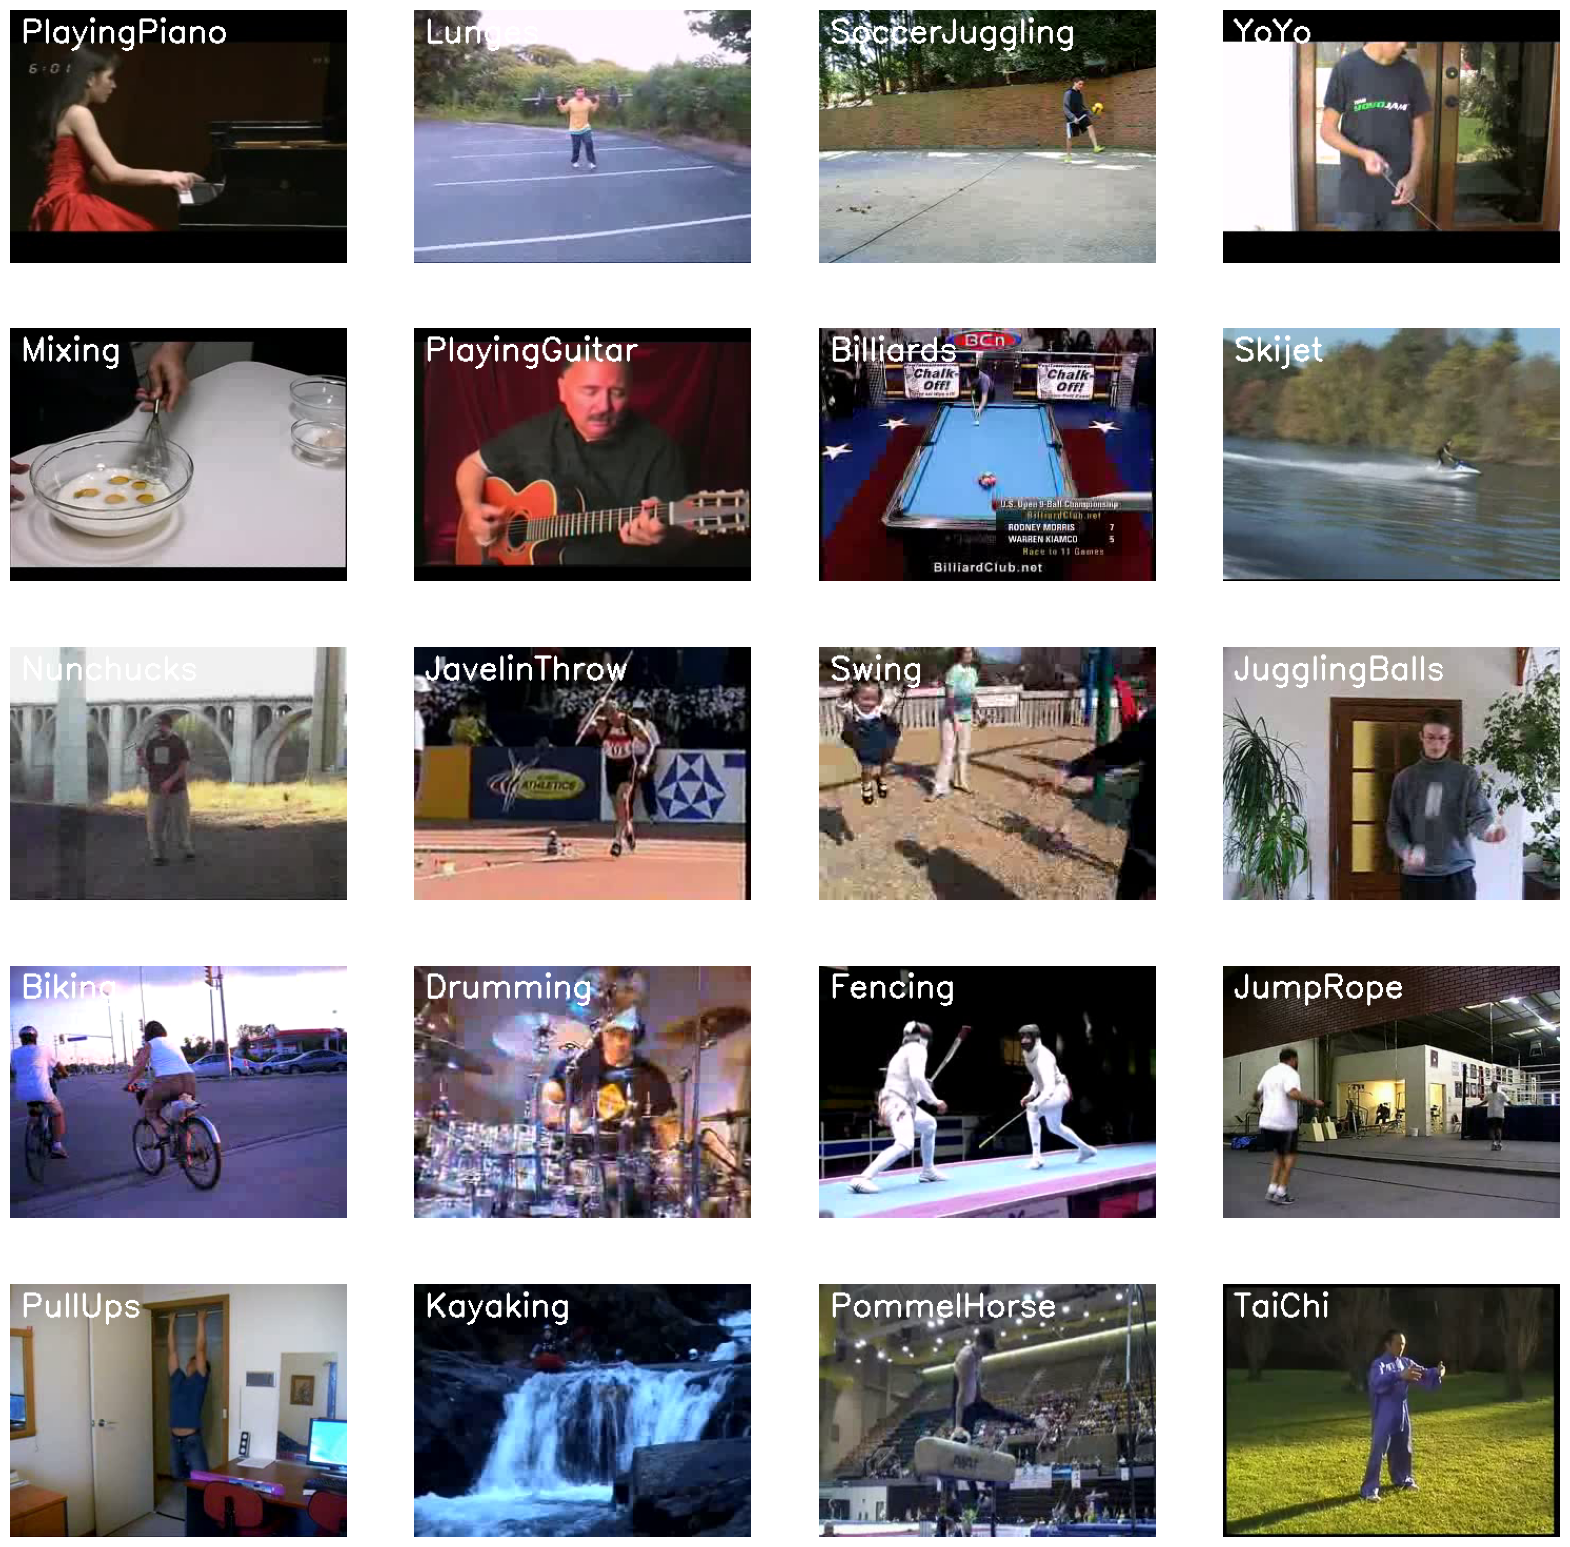

In [8]:
plt.figure(figsize=(20,20))

#generate a list of 20 random values bw 0-50 (50 total classes)
random_range = random.sample(range(len(all_classes_names)), 20)

dataset_path = "./realistic-action-recognition-ucf50/UCF50"


#Loop through the selected random classes:
for counter, random_index in enumerate(random_range, 1):

    #get the class name
    selected_class_name = all_classes_names[random_index]

    #get the list of video files from the particular class
    video_files_names_list = os.listdir(f"{dataset_path}/{selected_class_name}")

    #randomnly choose one video file from the randomnly selected class
    selected_video_file_name = random.choice(video_files_names_list)

    #create a VideoCapture object to read from the video file
    video_reader = cv2.VideoCapture(f"{dataset_path}/{selected_class_name}/{selected_video_file_name}")

    #read the first frame of the video file
    _, bgr_frame= video_reader.read()

    #release the object
    video_reader.release()

    #convert frame to RGB format
    rgb_frame=cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    #write class name
    cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

    #display frame
    plt.subplot(5,4, counter); plt.imshow(rgb_frame);plt.axis('off')



In [18]:
image_height, image_width = 64,64

sequence_length = 20 #number of frames of a video that will be fed to the model as one sequence

dataset_dir = "./realistic-action-recognition-ucf50/UCF50"

classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [19]:
def frames_extraction(video_path):

    #declare a list to store video frames
    frames_list=[]

    #read the video file using the VideoCapture object
    video_reader = cv2.VideoCapture(video_path)

    #get total frame count in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    #calculate the interval after which frames will be added to the list
    skip_frames_window = max(int(video_frames_count/sequence_length),1)

    #iterating thru video frames...
    for frame_counter in range(sequence_length):

        #set current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        #reading the frame from the videp
        success, frame=video_reader.read()

        #break loop if video frame is not successfully read
        if not success:
            break

        #frame resizing
        resized_frame= cv2.resize(frame, (image_height, image_width))

        #normalize the pixel values in the frame
        normalized_frame= resized_frame/255

        #append processed frame to this list
        frames_list.append(normalized_frame)

    #releasing the video file
    video_reader.release()

    #return processed frames as a list
    return frames_list

**Creating a function for dataset creation**


In [20]:
def create_dataset():

    # initializing lists to store the features (frames), labels , and video file paths
    features = []
    labels = []
    video_files_paths = []

    #loop thru each class...
    for class_index, class_name in enumerate(classes_list):

        print(f'Extracting data of class: {class_name}')

        #get list of video files in current class
        files_list = os.listdir(os.path.join(dataset_dir, class_name))

        #loop thru each video file
        for file_name in files_list:

            #file path for the current video file
            video_files_path = os.path.join(dataset_dir, class_name, file_name)

            #extract the frames usin prev declared function
            frames = frames_extraction(video_files_path)

            if len(frames) == sequence_length:

                # Append the extracted frames
                features.append(frames)
                # Append the corresponding class index
                labels.append(class_index)
                # Append the video file path
                video_files_paths.append(video_files_path)

    #convert to numpy arrays for models
    features = np.asarray(features)
    labels = np.array(labels)


    return features, labels, video_files_paths


In [21]:
features, labels, video_files_paths = create_dataset()

Extracting data of class: WalkingWithDog
Extracting data of class: TaiChi
Extracting data of class: Swing
Extracting data of class: HorseRace


In [22]:
one_hot_encoded_labels = to_categorical(labels)
#encode labels using keras tocategorical method

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size= 0.25, shuffle = True,
                                                                            random_state = seed_constant)

**Model Building**

In [28]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Activation
from tensorflow.keras.models import Model

def inception_3d_block(x, f1x1, f3x3_reduce, f3x3, f5x5_reduce, f5x5, fpool):
    #Path 1: 1x1x1 Convolution (Extracts basic features)**
    path1 = Conv3D(f1x1, (1, 1, 1), padding='same')(x)
    path1 = Activation('relu')(path1)

    #Path 2: 1x1x1 → 3x3x3 Convolution (Captures mid-range features)**
    path2 = Conv3D(f3x3_reduce, (1, 1, 1), padding='same')(x)  # Reduce depth
    path2 = Activation('relu')(path2)
    path2 = Conv3D(f3x3, (3, 3, 3), padding='same')(path2)  # 3D conv
    path2 = Activation('relu')(path2)

    #Path 3: 1x1x1 → 5x5x5 Convolution (Captures larger features)**
    path3 = Conv3D(f5x5_reduce, (1, 1, 1), padding='same')(x)  # Reduce depth
    path3 = Activation('relu')(path3)
    path3 = Conv3D(f5x5, (5, 5, 5), padding='same')(path3)  # 5x5x5 3D conv
    path3 = Activation('relu')(path3)

    #Path 4: 3x3x3 Max Pool → 1x1x1 Convolution (Captures background information)**
    path4 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(x)  # 3D pooling
    path4 = Conv3D(fpool, (1, 1, 1), padding='same')(path4)  # 1x1x1 conv after pooling
    path4 = Activation('relu')(path4)

    # Final Step: Concatenate all paths**
    return concatenate([path1, path2, path3, path4], axis=-1)  # Merge features


In [65]:
from tensorflow.keras.layers import GlobalAveragePooling3D, Dense
from tensorflow.keras.optimizers import Adam

def SimpleI3DNet(input_shape=(sequence_length, image_height, image_width, 3), num_classes=4):

    inputs = Input(shape=input_shape)

    # Initial 3D Convolution & Pooling
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    # First I3D Inception Block
    x = inception_3d_block(x, 64, 96, 128, 16, 32, 32)

    # Second I3D Inception Block
    x = inception_3d_block(x, 128, 128, 192, 32, 96, 64)

    # Pooling layer
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    # Third I3D Inception Block
    x = inception_3d_block(x, 192, 96, 208, 16, 48, 64)

    # Global Average Pooling
    x = GlobalAveragePooling3D()(x)
    x = Dropout(0.5)(x)

    # Fully connected layer for classification
    x = Dense(num_classes, activation='softmax')(x)


    # Define the model
    model = Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the I3D Model
model = SimpleI3DNet()
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 20, 64, 64, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_133 (Conv3D)       │ (None, 10, 32, 32, 64) │         65,920 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_133            │ (None, 10, 32, 32, 64) │              0 │ conv3d_133[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_35          │ (None, 5, 16, 16, 64)  │              0 │ activation_133[0][0]   │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_135 (Conv3D)       │ (None, 5, 16, 16, 96)  │          6,240 │ max_pooling3d_35[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_137 (Conv3D)       │ (None, 5, 16, 16, 16)  │          1,040 │ max_pooling3d_35[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_135            │ (None, 5, 16, 16, 96)  │              0 │ conv3d_135[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_137            │ (None, 5, 16, 16, 16)  │              0 │ conv3d_137[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_36          │ (None, 5, 16, 16, 64)  │              0 │ max_pooling3d_35[0][0] │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_134 (Conv3D)       │ (None, 5, 16, 16, 64)  │          4,160 │ max_pooling3d_35[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_136 (Conv3D)       │ (None, 5, 16, 16, 128) │        331,904 │ activation_135[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_138 (Conv3D)       │ (None, 5, 16, 16, 32)  │         64,032 │ activation_137[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_139 (Conv3D)       │ (None, 5, 16, 16, 32)  │          2,080 │ max_pooling3d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_134            │ (None, 5, 16, 16, 64)  │              0 │ conv3d_134[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_136            │ (None, 5, 16, 16, 128) │              0 │ conv3d_136[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_138       

 Total params: 2,428,132 (9.26 MB)

 Trainable params: 2,428,132 (9.26 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [67]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode = 'min', restore_best_weights = True)

In [68]:

model_training_history = model.fit(
                            x=features_train,
                            y=labels_train,
                            epochs=100,
                            batch_size=8, shuffle=True,
                            validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 334ms/step - accuracy: 0.2532 - loss: 1.3881 - val_accuracy: 0.3562 - val_loss: 1.3435
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2671 - loss: 1.3681 - val_accuracy: 0.3562 - val_loss: 1.3360
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3115 - loss: 1.3600 - val_accuracy: 0.3562 - val_loss: 1.3163
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2844 - loss: 1.3515 - val_accuracy: 0.4795 - val_loss: 1.3138
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3735 - loss: 1.3102 - val_accuracy: 0.3562 - val_loss: 1.3318
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2831 - loss: 1.3942 - val_accuracy: 0.6164 - val_loss: 1.1216
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4565 - loss: 1.1593 - val_accuracy: 0.6575 - val_loss: 0.9365
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3923 - loss: 1.1520 - val_accuracy: 

In [69]:
#tried increasing batch size to 16 which helped validation accuracy

In [63]:

model_training_history2 = model.fit(
                            x=features_train,
                            y=labels_train,
                            epochs=50,
                            batch_size=16, shuffle=True,
                            validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 779ms/step - accuracy: 0.2712 - loss: 1.3885 - val_accuracy: 0.3562 - val_loss: 1.3427
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.2270 - loss: 1.3864 - val_accuracy: 0.2466 - val_loss: 1.3562
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.2937 - loss: 1.3677 - val_accuracy: 0.3425 - val_loss: 1.3286
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.2647 - loss: 1.3575 - val_accuracy: 0.3836 - val_loss: 1.2894
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.3644 - loss: 1.3306 - val_accuracy: 0.5479 - val_loss: 1.2376
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.3922 - loss: 1.2902 - val_accuracy: 0.5205 - val_loss: 1.1966
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.4014 - loss: 1.2388 - val_accuracy: 0.3836 - val_loss: 1.2288
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.3774 - loss: 1.2064 - val_accuracy: 0

In [70]:
#increasing batch size to 24 made it worse
model_training_history2 = model.fit(
                            x=features_train,
                            y=labels_train,
                            epochs=60,
                            batch_size=24, shuffle=True,
                            validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 452ms/step - accuracy: 0.8910 - loss: 0.2866 - val_accuracy: 0.8767 - val_loss: 0.3457
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.8936 - loss: 0.2746 - val_accuracy: 0.8219 - val_loss: 0.4192
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9369 - loss: 0.2471 - val_accuracy: 0.8493 - val_loss: 0.4187
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.8690 - loss: 0.2763 - val_accuracy: 0.8630 - val_loss: 0.4173
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9207 - loss: 0.2181 - val_accuracy: 0.8493 - val_loss: 0.3717
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9236 - loss: 0.2318 - val_accuracy: 0.8219 - val_loss: 0.4060
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9703 - loss: 0.1399 - val_accuracy: 0.8630 - val_loss: 0.3178
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.9367 - loss: 0.1646 - val_accuracy: 0

In [71]:
#note: Adding a dropout layer which wasnt present before helped